In [1]:
#bibliotecas
import pandas as pd
import os
#import holidays
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

In [2]:
#definir o diretório
os.chdir(os.getcwd()[:-9])

In [3]:
#importar dataset
df = pd.read_parquet("data/processed/df_vendas.parquet")
df.data = pd.to_datetime(df.data, format="%d/%m/%Y")

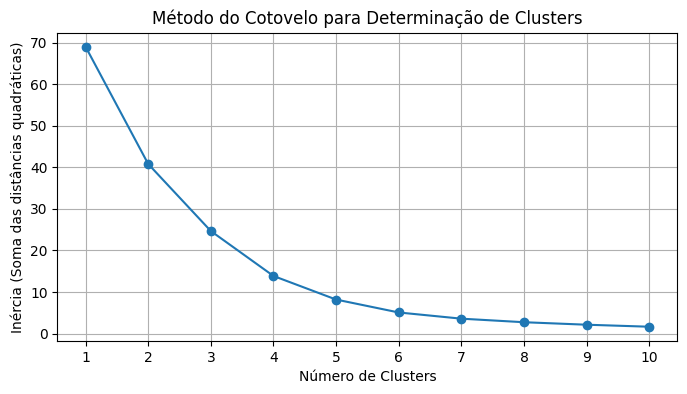

In [4]:
# Criar features agregadas para cada produto
product_features = df.groupby('xfantemit').agg({
    'qcom': ['mean', 'std', 'count'],
}).fillna(0)

# Ajustar os nomes das colunas (remover multi-index)
product_features.columns = ['y_mean', 'y_std', 'y_count']

# Padronização dos dados
scaler = StandardScaler()
product_features_scaled = scaler.fit_transform(product_features)

# Método do cotovelo para determinar o número ideal de clusters
inertia = []
k_range = range(1, 11)  # Testando de 1 a 10 clusters

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(product_features_scaled)
    inertia.append(kmeans.inertia_)

# Plot do método do cotovelo
plt.figure(figsize=(8, 4))
plt.plot(k_range, inertia, marker='o')
plt.title('Método do Cotovelo para Determinação de Clusters')
plt.xlabel('Número de Clusters')
plt.ylabel('Inércia (Soma das distâncias quadráticas)')
plt.xticks(k_range)
plt.grid(True)
plt.show()

In [5]:
# Clusterização final
n_clusters = 3
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
clusters = kmeans.fit_predict(product_features_scaled)

# Mapear os clusters de volta para o DataFrame original
# (Assumindo que 'product_features' tem o mesmo índice que 'df['sku']')
df['cluster'] = df['xfantemit'].map(dict(zip(product_features.index, clusters)))

In [7]:
# Atribuir pesos inversamente proporcionais à frequência
product_weights = df['cod'].value_counts(normalize=True).rdiv(1)
df['sample_weight'] = df['cod'].map(product_weights)

In [8]:
#salvar as alterações
df.to_parquet("data/processed/vendas_engineered.parquet", index=False)

In [6]:
# Lags (vendas passadas)
def create_lags(df, lags=[1, 2, 3, 7]):
    df = df.sort_values("data_venda")
    for lag in lags:
        df[f"lag_{lag}"] = df["venda"].shift(lag)
    return df

df = df.groupby("sku").apply(create_lags).reset_index(drop=True)

C:\Users\marce\AppData\Local\Temp\ipykernel_21508\851300138.py:8: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby("sku").apply(create_lags).reset_index(drop=True)


In [7]:
# Médias móveis (rolling)
def create_rolling(df, windows=[3, 7]):
    for window in windows:
        df[f"rolling_mean_{window}"] = df["venda"].rolling(window).mean()
    return df

df = df.groupby("sku").apply(create_rolling).reset_index(drop=True)
df.head(10)

C:\Users\marce\AppData\Local\Temp\ipykernel_21508\2337579250.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby("sku").apply(create_rolling).reset_index(drop=True)


,sku,data_venda,venda,dia_da_semana,mes,dia_do_mes,fim_de_semana,feriado,lag_1,lag_2,lag_3,lag_7,rolling_mean_3,rolling_mean_7
0,1,2024-01-16,13,1,1,16,0,0,NaN,NaN,NaN,NaN,NaN,NaN
1,1,2024-01-17,17,2,1,17,0,0,13.0,NaN,NaN,NaN,NaN,NaN
2,1,2024-01-18,18,3,1,18,0,0,17.0,13.0,NaN,NaN,16.000000,NaN
3,1,2024-01-19,16,4,1,19,0,0,18.0,17.0,13.0,NaN,17.000000,NaN
4,1,2024-01-20,29,5,1,20,1,0,16.0,18.0,17.0,NaN,21.000000,NaN
5,1,2024-01-21,14,6,1,21,1,0,29.0,16.0,18.0,NaN,19.666667,NaN
6,1,2024-01-25,13,3,1,25,0,0,14.0,29.0,16.0,NaN,18.666667,17.142857
7,1,2024-01-26,14,4,1,26,0,0,13.0,14.0,29.0,13.0,13.666667,17.285714
8,1,2024-01-27,16,5,1,27,1,0,14.0,13.0,14.0,17.0,14.333333,17.142857
9,1,2024-01-29,11,0,1,29,0,0,16.0,14.0,13.0,18.0,13.666667,16.142857


In [21]:
#salvar as alterações
df.to_parquet("data/processed/vendas_engineered.parquet", index=False)